# Introduction

Today we will train CNN ensemble using cosine annealing and model checkpoints for the MNIST dataset classification task.

# Settings

Import required libs and check Tensorflow version

In [1]:
import numpy as np
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection as ms
import sklearn.preprocessing as p
import math

In [2]:
tf.version.VERSION

'2.2.0'

# Import data

In [3]:
mnist = pd.read_csv('../input/digit-recognizer/train.csv')

Check shape and where is the 'label' column

In [4]:
mnist.shape, mnist.columns

((42000, 785),
 Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
        'pixel6', 'pixel7', 'pixel8',
        ...
        'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
        'pixel780', 'pixel781', 'pixel782', 'pixel783'],
       dtype='object', length=785))

In [5]:
height = 28
width = 28
channels = 1

In [6]:
n_outputs = 10

# Data visualization

Let's define a few functions for displaying images

In [7]:
def show_digit(digit):
    plt.imshow(digit.reshape(height, width))
    plt.show()

In [8]:
def show_digit_and_print_label(row):
    print(row.loc['label'], ':')
    show_digit(row.loc[mnist.columns != 'label'].values)

1 :


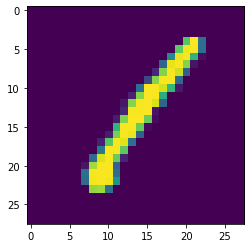

0 :


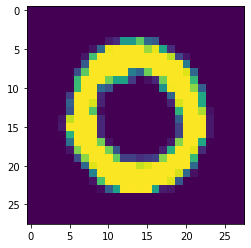

1 :


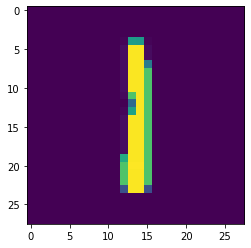

4 :


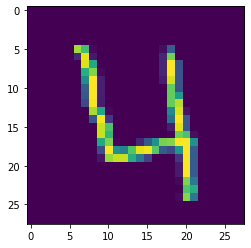

0    None
1    None
2    None
3    None
dtype: object

In [9]:
mnist.loc[:3].apply(show_digit_and_print_label, axis=1)


# Data preprocessing

Now we need to split the dataset on the train and validation parts

In [10]:
X_data = mnist.drop(columns='label')
y_data = mnist['label']

In [11]:
y_data = tf.keras.utils.to_categorical(y_data, num_classes = n_outputs)
y_data.shape

(42000, 10)

In [12]:
X_train, X_val, y_train, y_val  = ms.train_test_split(X_data, y_data, test_size=0.15)

In [13]:
scaler = p.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = X_train.reshape(-1, height, width, channels)

X_val = scaler.transform(X_val)
X_val = X_val.reshape(-1, height, width, channels)

In [14]:
X_train.shape, X_val.shape

((35700, 28, 28, 1), (6300, 28, 28, 1))

In [15]:
y_train.shape, y_val.shape

((35700, 10), (6300, 10))

# Data augmentation

I also want to apply data augmentation for our models, let's define ImageDataGenerator

In [16]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1
) 

In [17]:
batch_size = 250

In [18]:
train_data_gen = image_gen.flow(X_train, y=y_train, batch_size=batch_size)

# Cosine annealing and model checkpoints

Work on this learning rate and checkpoint callback is the most interesting thing in this notebook for me.

Here is the original paper about snapshot ensembles with the cosine annealing: https://arxiv.org/pdf/1704.00109.pdf

This image best describes the used ensemble creation method:

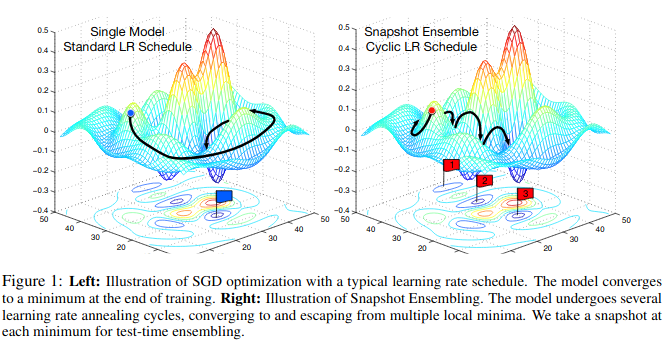

In [19]:
class CosineAnnealingLearningRateCallback(tf.keras.callbacks.Callback):

    def __init__(self, n_epochs, n_cycles, lrate_max, n_epochs_for_saving, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.n_epochs_for_saving = n_epochs_for_saving
        self.best_val_acc_per_cycle = float('-inf')
        
    # allow to save model only in the last n_epochs_for_saving  
    def is_save_range(self, epoch, epochs_per_cycle, n_epochs_for_saving):
        epoch += 1

        f, d = math.modf(epoch / epochs_per_cycle)
        next_end = epochs_per_cycle * (d + (1 if f > 0 else 0))

        need_to_save = epoch > (next_end - n_epochs_for_saving) 
        return need_to_save

    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = math.floor(n_epochs/n_cycles)
        cos_inner = (math.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (math.cos(cos_inner) + 1)
    
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        
    # make a snapshots if necessary
    def on_epoch_end(self, epoch, logs={}):
        # check if we can save model
        epochs_per_cycle = math.floor(self.epochs / self.cycles)
        
        if epoch % epochs_per_cycle == 0:
            self.best_val_acc_per_cycle = float('-inf')
            
            #test log
            #print('MyCheckpointer. New cycle - best_val_acc_per_cycle has been erased')
        
        isr = self.is_save_range(epoch, epochs_per_cycle, self.n_epochs_for_saving)
        
        last_val_acc = logs['val_accuracy']
        
        #test logs
        #print('MyCheckpointer. epoch: ', epoch)
        #print('MyCheckpointer. epochs_per_cycle: ', epochs_per_cycle)
        #print('MyCheckpointer. isr: ', isr)
        #print('MyCheckpointer. best_val_acc_per_cycle: ', self.best_val_acc_per_cycle, ', last_val_acc: ', last_val_acc)
        
        # check is snapshot necessary 
        if epoch != 0 and isr and last_val_acc > self.best_val_acc_per_cycle:
            self.best_val_acc_per_cycle = last_val_acc
            
            # save model to file
            filename = f'snapshot_model_{epoch // epochs_per_cycle}.h5'
            self.model.save(filename)
            print(f'saved snapshot {filename}, epoch: {epoch}, val_accuracy: {last_val_acc:.5f}')
        
# we can also play with these hyperparameters         
n_epochs = 300
n_cycles = n_epochs / 50
n_epochs_for_saving = 20

calrc = CosineAnnealingLearningRateCallback(n_epochs, n_cycles, 0.01, n_epochs_for_saving)

# Modeling

This was preceded by a lot of manual and auto hyperparameters tuning sessions and different model architectures testing, but now I skip this so as not to confuse the reader.

In [20]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, 3, 1, padding='same', activation='relu', input_shape=(height, width, channels)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(32, 3, 1, padding='same', activation='relu', input_shape=(height, width, channels)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.20))


model.add(tf.keras.layers.Conv2D(64, 3, 1, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64, 3, 1, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.20))


model.add(tf.keras.layers.Conv2D(128, 3, 1, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.20))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
model.fit(train_data_gen, batch_size=batch_size, epochs = n_epochs, validation_data = (X_val, y_val), callbacks=[calrc], verbose=2)

Epoch 1/300
143/143 - 11s - loss: 0.2684 - accuracy: 0.9195 - val_loss: 5.3408 - val_accuracy: 0.3213
Epoch 2/300
143/143 - 11s - loss: 0.0956 - accuracy: 0.9704 - val_loss: 0.2118 - val_accuracy: 0.9298
Epoch 3/300
143/143 - 11s - loss: 0.0702 - accuracy: 0.9782 - val_loss: 0.0428 - val_accuracy: 0.9875
Epoch 4/300
143/143 - 11s - loss: 0.0634 - accuracy: 0.9803 - val_loss: 0.0267 - val_accuracy: 0.9917
Epoch 5/300
143/143 - 11s - loss: 0.0553 - accuracy: 0.9831 - val_loss: 0.0390 - val_accuracy: 0.9890
Epoch 6/300
143/143 - 11s - loss: 0.0469 - accuracy: 0.9853 - val_loss: 0.0313 - val_accuracy: 0.9911
Epoch 7/300
143/143 - 10s - loss: 0.0470 - accuracy: 0.9856 - val_loss: 0.0258 - val_accuracy: 0.9927
Epoch 8/300
143/143 - 11s - loss: 0.0411 - accuracy: 0.9871 - val_loss: 0.0517 - val_accuracy: 0.9830
Epoch 9/300
143/143 - 11s - loss: 0.0384 - accuracy: 0.9882 - val_loss: 0.0193 - val_accuracy: 0.9940
Epoch 10/300
143/143 - 10s - loss: 0.0368 - accuracy: 0.9884 - val_loss: 0.0235 - 

# Trained ensemble usage

Now let's define a few functions for the ensemble usage

In [22]:
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        filename = f'snapshot_model_{str(i)}.h5'
        model = tf.keras.models.load_model(filename)
        all_models.append(model)
    return all_models
 
def ensemble_predictions(models, testX):
    yhats = [model.predict(testX) for model in models]
    yhats = np.array(yhats)
    summed = np.sum(yhats, axis=0)
    result = np.argmax(summed, axis=1)
    return result
 
def evaluate_n_models(models, n_models, testX, testy):
    subset = models[:n_models]
    yhat = ensemble_predictions(subset, testX)
    return sk.metrics.accuracy_score(testy, yhat)

And load and test our models

1: single=0.99698, ensemble=0.99698
2: single=0.99746, ensemble=0.99778
3: single=0.99762, ensemble=0.99762
4: single=0.99778, ensemble=0.99746
5: single=0.99762, ensemble=0.99762
6: single=0.99778, ensemble=0.99762


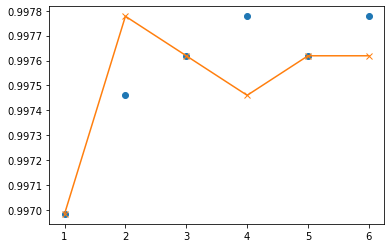

In [23]:
models = load_all_models(6)

single_scores, ensemble_scores = list(), list()
for i in range(1, len(models)+1):

    ensemble_score = evaluate_n_models(models, i, X_val, np.argmax(y_val, axis=1))

    _, single_score = models[i-1].evaluate(X_val, y_val, verbose=0)

    print(f'{i}: single={single_score:.5f}, ensemble={ensemble_score:.5f}')
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

x_axis = [i for i in range(1, len(models)+1)]
plt.plot(x_axis, single_scores, marker='o', linestyle='None')
plt.plot(x_axis, ensemble_scores, marker='x')
plt.show()

# Predicting

Let's use our ensemble as intended

In [24]:
X_pred = pd.read_csv('../input/digit-recognizer/test.csv')
X_pred = scaler.transform(X_pred)
X_pred = X_pred.reshape(-1, height, width, channels)

In [25]:
y_pred = pd.DataFrame()
y_pred['ImageId'] = pd.Series(range(1,X_pred.shape[0] + 1))
y_pred['Label'] = ensemble_predictions(models, X_pred)

y_pred.to_csv("submission.csv", index=False)

# Conclusion

This learning rate cosine annealing ensemble creation method with another used techniques gives pretty good results. Cosine annealing is also quite intuitive and easy to use learning rate scheduling method.